## Link for dataset : https://drive.google.com/drive/folders/1Epbvg4neND0bU25aZDg3pJFpej9BciQ1?usp=sharing



# Only accessed using IIT Jammu Mail

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from glob import glob
import pickle
import tensorflow as tf


KeyboardInterrupt



In [3]:
data_path = "C:/Users/OM/Downloads/SegNet-Semantic-Segmentation-master/SegNet-Semantic-Segmentation-master/Dataset" 
train_path = "C:/Users/OM/Downloads/SegNet-Semantic-Segmentation-master/SegNet-Semantic-Segmentation-master/Dataset/train/"
train_label_path = "C:/Users/OM/Downloads/SegNet-Semantic-Segmentation-master/SegNet-Semantic-Segmentation-master/Dataset/trainannot/"
valid_path = "C:/Users/OM/Downloads/SegNet-Semantic-Segmentation-master/SegNet-Semantic-Segmentation-master/Dataset/val/"
valid_label_path = "C:/Users/OM/Downloads/SegNet-Semantic-Segmentation-master/SegNet-Semantic-Segmentation-master/Dataset/valannot/"
test_path = "C:/Users/OM/Downloads/SegNet-Semantic-Segmentation-master/SegNet-Semantic-Segmentation-master/Dataset/test/"
test_label_path = "C:/Users/OM/Downloads/SegNet-Semantic-Segmentation-master/SegNet-Semantic-Segmentation-master/Dataset/testannot/"
train_file = data_path + "train.p"
valid_file = data_path + "val.p"
test_file = data_path + "test.p"

In [4]:
train_list = sorted(glob(train_path + "*.png"))
train_label_list = sorted(glob(train_label_path + "*.png"))

valid_list = sorted(glob(valid_path + "*.png"))
valid_label_list = sorted(glob(valid_label_path + "*.png"))

test_list = sorted(glob(test_path + "*.png"))
test_label_list = sorted(glob(test_label_path + "*.png"))

In [5]:
def binarylab(labels):
    x = np.zeros([labels.shape[0],labels.shape[1],12])  
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            x[i,j,labels[i][j]]=1
    return x

def make_dataset(image_list, mask_list):
    images = []
    masks = []
    
    for img, mask in zip(image_list, mask_list):
        images.append(cv2.resize(cv2.imread(img), (224,224)))      # 224X224
        masks.append(binarylab(cv2.resize(cv2.imread(mask), (224,224))))

    images = np.array(images)
    masks = np.array(masks)
    return images, masks
    

In [6]:
X_train, y_train = make_dataset(train_list, train_label_list)
X_val, y_val = make_dataset(valid_list, valid_label_list)
X_test, y_test = make_dataset(test_list, test_label_list)

In [7]:
X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

(<Axes: >,
 (-0.5, 223.5, 223.5, -0.5))

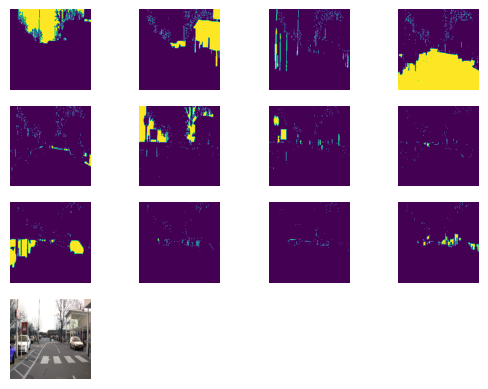

In [8]:
from matplotlib.gridspec import GridSpec
from random import randint, sample
ranidx = randint(0, len(y_train))
gs = GridSpec(4,4)
plt.figure(dpi=100)
for i in range(4*3):
    plt.subplot(gs[i]), plt.imshow(y_train[ranidx][:,:,i]), plt.axis('off')
    
plt.subplot(gs[12]), plt.imshow(X_train[ranidx]), plt.axis('off')

In [9]:
num_classes = 12
input_shape = X_train.shape[1:] #(480,480,3)
smooth = 1.
nproc = 8

In [10]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
import tensorflow as tf

class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding='same', **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        print("MaxPoolingWithArgmax2D call")
        pool_size = [1, self.pool_size[0], self.pool_size[1], 1]
        strides = [1, self.strides[0], self.strides[1], 1]
        padding = self.padding.upper()
        
        output, argmax = tf.nn.max_pool_with_argmax(
            inputs,
            ksize=pool_size,
            strides=strides,
            padding=padding
        )
        argmax = tf.cast(argmax, tf.float32)
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        print("MaxPoolingWithArgmax2D compute_output_shape")
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx] if dim is not None else None
            for idx, dim in enumerate(input_shape)
        ]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        print("MaxPoolingWithArgmax2D compute_mask")
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        print("MaxUnpooling2D call")
        updates, mask = inputs[0], inputs[1]
        mask = tf.cast(mask, 'int32')
        input_shape = tf.shape(updates, out_type='int32')

        if output_shape is None:
            output_shape = (
                input_shape[0],
                input_shape[1] * self.size[0],
                input_shape[2] * self.size[1],
                input_shape[3]
            )
        self.output_shape1 = output_shape

        one_like_mask = tf.ones_like(mask, dtype='int32')
        batch_shape = tf.concat([[input_shape[0]], [1], [1], [1]], axis=0)
        batch_range = tf.reshape(tf.range(output_shape[0], dtype='int32'), shape=batch_shape)
        b = one_like_mask * batch_range

        y = mask // (output_shape[2] * output_shape[3])
        x = (mask // output_shape[3]) % output_shape[2]
        feature_range = tf.range(output_shape[3], dtype='int32')
        f = one_like_mask * feature_range

        updates_size = tf.size(updates)
        indices = tf.transpose(tf.reshape(tf.stack([b, y, x, f]), [4, updates_size]))
        values = tf.reshape(updates, [updates_size])
        ret = tf.scatter_nd(indices, values, output_shape)
        return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3]
        )


In [11]:
from keras.models import Model
from keras.layers import Input, Activation, Reshape, Dense, Conv2D, BatchNormalization

# Ensure that MaxPoolingWithArgmax2D and MaxUnpooling2D are defined or imported
# from layers import MaxPoolingWithArgmax2D, MaxUnpooling2D

def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Conv2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv1")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Conv2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block1_conv2")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)
    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size, name="block1_pool")(conv_2)

    conv_3 = Conv2D(128, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block2_conv1")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Conv2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal',  name="block2_conv2")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size, name="block2_pool")(conv_4)

    conv_5 = Conv2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv1")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Conv2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv2")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Conv2D(256, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block3_conv3")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size, name="block3_pool")(conv_7)

    conv_8 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block4_conv1")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Conv2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv2")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Conv2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal', name="block4_conv3")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size, name="block4_pool")(conv_10)

    conv_11 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal', name="block5_conv1")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Conv2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv2")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Conv2D(512, (kernel, kernel), padding="same" , kernel_initializer='he_normal',  name="block5_conv3")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size, name="block5_pool")(conv_13)
   
    # decoder
    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Conv2D(512, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Conv2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Conv2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Conv2D(256, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Conv2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Conv2D(128, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Conv2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Conv2D(64, (kernel, kernel), padding="same", kernel_initializer='he_normal')(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Conv2D(n_labels, (1, 1), padding="same", kernel_initializer='he_normal')(conv_25)
    conv_26 = BatchNormalization()(conv_26)

    conv_26 = Dense(12)(conv_26)
    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model


In [12]:
VGG16_MODEL=tf.keras.applications.VGG16(include_top=False, weights='imagenet')

In [13]:
VGG16_MODEL.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model= segnet(input_shape=input_shape, n_labels=12)
model.summary()

MaxPoolingWithArgmax2D compute_output_shape
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D compute_output_shape
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D compute_output_shape
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D compute_output_shape
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D compute_output_shape
MaxPoolingWithArgmax2D compute_mask
Build decoder done..


Model: "SegNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 224, 224, 64)      │           1,792 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 224, 224, 64)      │             256 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 224, 224, 64)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 224, 224, 64)      │          36,928 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 224, 224, 64)      │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 224, 224, 64)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool                   │ [(None, 112, 112, 64),    │               0 │ activation_1[0][0]         │
│ (MaxPoolingWithArgmax2D)      │ (None, 112, 112, 64)]     │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 112, 112, 128)     │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 112, 112, 128)     │             512 │ block2_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 112, 112, 128)     │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 112, 112, 128)     │         147,584 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 112, 112, 128)     │             512 │ block2_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 112, 112, 128)     │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool                   │ [(None, 56, 56, 128),     │               

 Total params: 29,459,864 (112.38 MB)

 Trainable params: 29,443,968 (112.32 MB)

 Non-trainable params: 15,896 (62.09 KB)

In [15]:
from tensorflow.keras.layers import Conv2D
layers = model.layers
merged_layers = []
count = 1
for _layer in layers:
    if isinstance(_layer, Conv2D):
        merged_layers.append(_layer)
    if _layer.name == "block2_pool":
        break

vgg_layer =[]
vgg_layers = VGG16_MODEL.layers
for _layer in vgg_layers:
    if isinstance(_layer, Conv2D):
        vgg_layer.append(_layer)

for seg_model, vgg_model in zip(merged_layers, vgg_layer):
    wk0 = vgg_model.get_weights()
    seg_model.set_weights(wk0)

In [16]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['acc'])

In [17]:
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=5,
                    shuffle=True,
                    validation_split=0.1)

Epoch 1/5
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxUnpooling2D call
MaxUnpooling2D call
MaxUnpooling2D call
MaxUnpooling2D call
MaxUnpooling2D call
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxUnpooling2D call
MaxUnpooling2D call
MaxUnpooling2D call
MaxUnpooling2D call
MaxUnpooling2D call
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - acc: 0.2910 - loss: 2.2148 MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgm

In [18]:
history.history.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])

In [19]:
model.evaluate(X_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 155s 18s/step - acc: 0.4958 - loss: 2.1646


[1.9883438348770142, 0.5339754223823547]

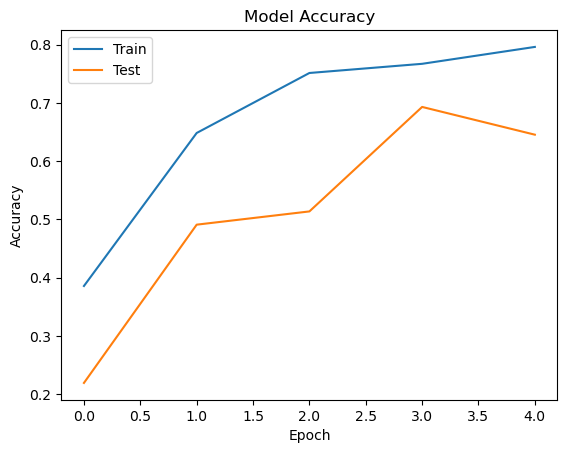

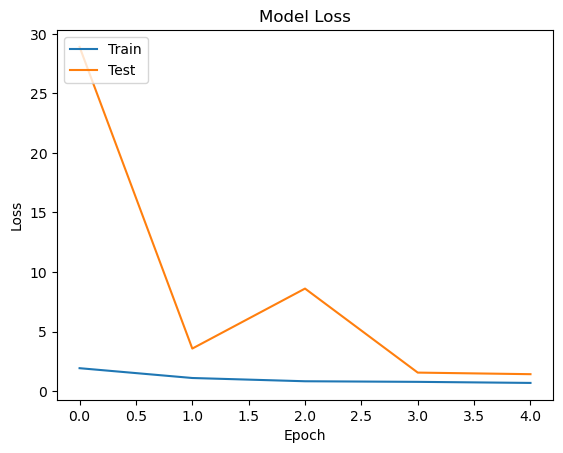

In [20]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxUnpooling2D call
MaxUnpooling2D call
MaxUnpooling2D call
MaxUnpooling2D call
MaxUnpooling2D call
7/8 ━━━━━━━━━━━━━━━━━━━━ 19s 20s/stepMaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxPoolingWithArgmax2D call
MaxPoolingWithArgmax2D compute_mask
MaxUnpooling2D call
MaxUnpooling2D call
MaxUnpooling2D call
MaxUnpooling2D call
MaxUnpooling2D call
8/8 ━━━━━━━━━━━━━━━━━━━━ 176s 19s/step


(<Figure size 640x480 with 1 Axes>,
 (-0.5, 223.5, 223.5, -0.5))

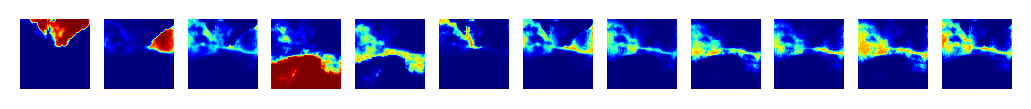

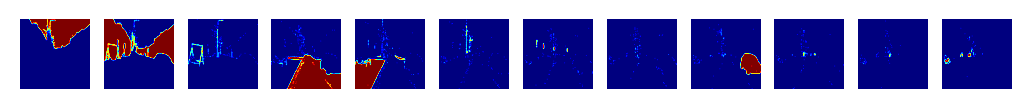

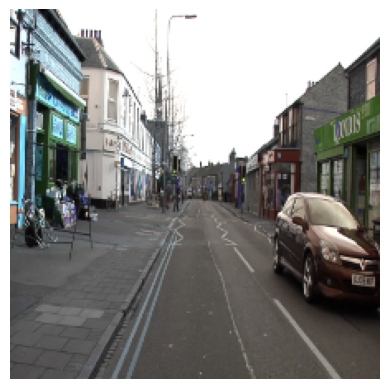

In [22]:
pred = model.predict(X_test, verbose=1)

ranidx = randint(0, len(y_test))
gs = GridSpec(1,12)
plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(pred[ranidx][:,:,i], cmap='jet'), plt.axis('off')

plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(y_test[ranidx][:,:,i],cmap='jet'), plt.axis('off')
    
plt.figure(),plt.imshow(X_test[ranidx]), plt.axis('off')
     

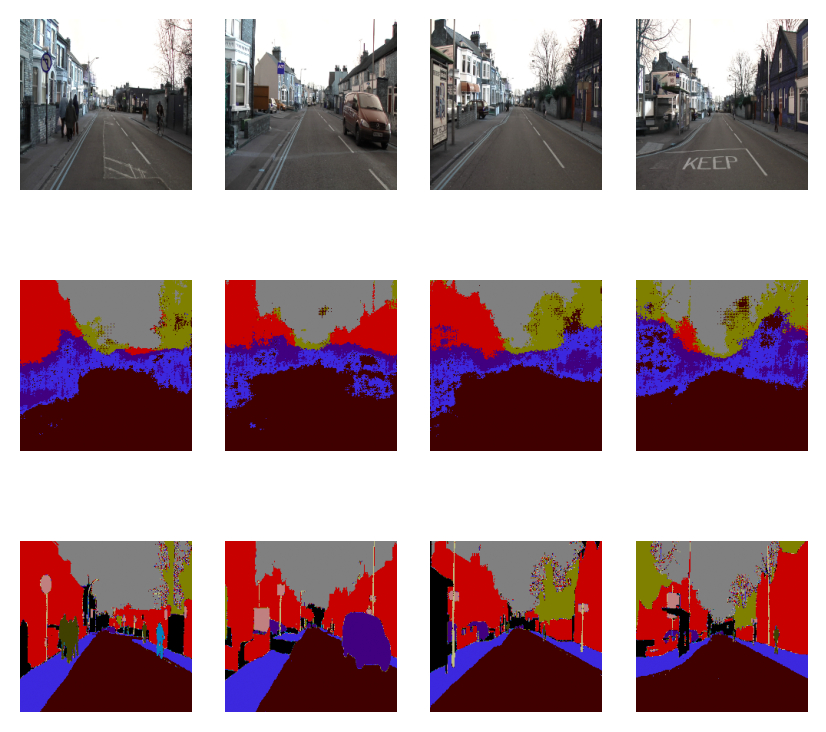

In [33]:
Sky = [128,128,128]
Building = [200,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [64,0,0]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in range(12):
        r[temp==l]=label_colours[l,0]                                                         
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

randsample = sample(range(222,len(pred)), 4)
gs = GridSpec(3,5)
plt.figure(dpi=200)

for i in range(4):
    output = visualize(np.argmax(pred[randsample[i]],axis=2).reshape((224,224)), plot=False)
    out_test = visualize(np.argmax(y_test[randsample[i]],axis=2).reshape((224,224)), plot=False)
        
    plt.subplot(gs[i]), plt.imshow(X_test[randsample[i]]), plt.axis('off')
    plt.subplot(gs[5+i]), plt.imshow(output), plt.axis('off')
    plt.subplot(gs[10+i]), plt.imshow(out_test), plt.axis('off')

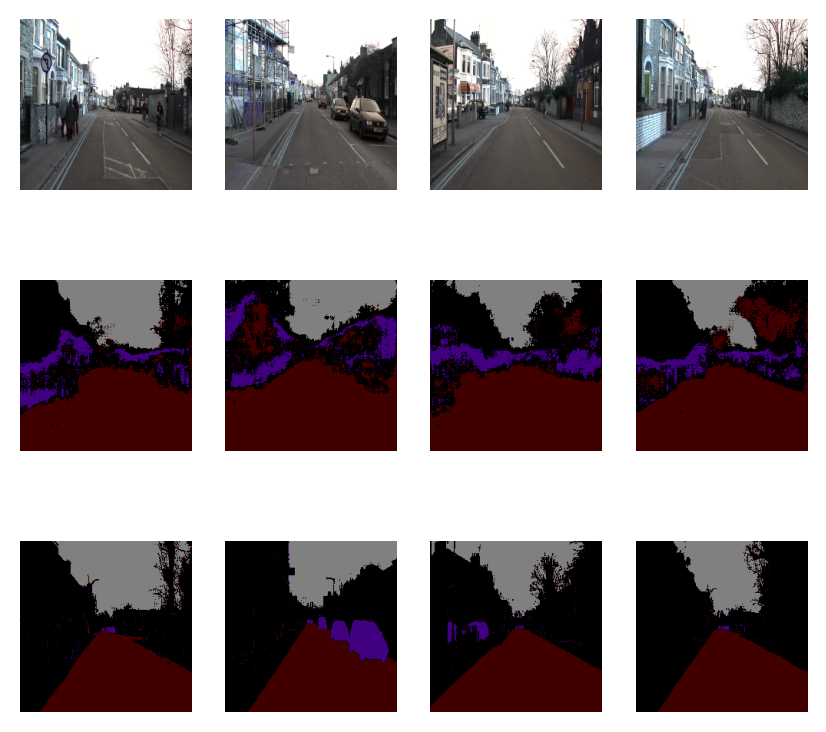

In [29]:
Sky = [128,128,128]
Building = [0,0,0]
Pole =[0,0,0]
Road_marking = [0,0,0]
Road = [64,0,0]
Pavement = [0,0,0]
Tree = [0,0,0]
SignSymbol = [0,0,0]
Fence = [0,0,0]
Car = [64,0,128]
Pedestrian = [0,0,0]
Bicyclist = [0,0,0]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in range(12):
        r[temp==l]=label_colours[l,0]                                                         
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

randsample = sample(range(222,len(pred)), 4)
gs = GridSpec(3,5)
plt.figure(dpi=200)

for i in range(4):
    output = visualize(np.argmax(pred[randsample[i]],axis=2).reshape((224,224)), plot=False)
    out_test = visualize(np.argmax(y_test[randsample[i]],axis=2).reshape((224,224)), plot=False)
        
    plt.subplot(gs[i]), plt.imshow(X_test[randsample[i]]), plt.axis('off')
    plt.subplot(gs[5+i]), plt.imshow(output), plt.axis('off')
    plt.subplot(gs[10+i]), plt.imshow(out_test), plt.axis('off')

# Update

In [100]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Activation, BatchNormalization

# Function to load and preprocess images and masks
def load_and_preprocess(image_dir, mask_dir):
    image_files = os.listdir(image_dir)
    images = []
    masks = []
    
    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file)
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        images.append(img)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (224, 224))
        mask = np.expand_dims(mask, axis=-1)
        masks.append(mask)
    
    images = np.array(images)
    masks = np.array(masks)
    
    return images, masks

train_path = "C:/Users/OM/Downloads/SegNet-Semantic-Segmentation-master/SegNet-Semantic-Segmentation-master/Dataset/train/"
train_label_path = "C:/Users/OM/Downloads/SegNet-Semantic-Segmentation-master/SegNet-Semantic-Segmentation-master/Dataset/trainannot/"
valid_path = "C:/Users/OM/Downloads/SegNet-Semantic-Segmentation-master/SegNet-Semantic-Segmentation-master/Dataset/val/"
valid_label_path = "C:/Users/OM/Downloads/SegNet-Semantic-Segmentation-master/SegNet-Semantic-Segmentation-master/Dataset/valannot/"
test_path = "C:/Users/OM/Downloads/SegNet-Semantic-Segmentation-master/SegNet-Semantic-Segmentation-master/Dataset/test/"
test_label_path = "C:/Users/OM/Downloads/SegNet-Semantic-Segmentation-master/SegNet-Semantic-Segmentation-master/Dataset/testannot/"
X_train, y_train = load_and_preprocess(train_path, train_label_path)
X_valid, y_valid = load_and_preprocess(valid_path, valid_label_path)
X_test, y_test = load_and_preprocess(test_path, test_label_path)


In [42]:
def simple_cnn(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    
    # Decoder
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), padding='same')(x)
    outputs = Activation('sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

input_shape = (224, 224, 3)
model = simple_cnn(input_shape)
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 112, 112, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 224, 224, 1)         │             289 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 224, 224, 1)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,657 (151.00 KB)

 Trainable params: 38,401 (150.00 KB)

 Non-trainable params: 256 (1.00 KB)

# using adam optimizer and loss function: categorial crossentropy with less batch size and more epochs

In [43]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
adam_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, 
                    epochs=5, 
                    batch_size=3, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)


Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 26s 177ms/step - accuracy: 0.3398 - loss: 0.0000e+00 - val_accuracy: 0.3345 - val_loss: 0.0000e+00
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.3597 - loss: 0.0000e+00 - val_accuracy: 0.3415 - val_loss: 0.0000e+00
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.3611 - loss: 0.0000e+00 - val_accuracy: 0.3411 - val_loss: 0.0000e+00
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 29s 232ms/step - accuracy: 0.3601 - loss: 0.0000e+00 - val_accuracy: 0.3357 - val_loss: 0.0000e+00
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 28s 228ms/step - accuracy: 0.3575 - loss: 0.0000e+00 - val_accuracy: 0.3405 - val_loss: 0.0000e+00


In [44]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 337ms/step - accuracy: 0.3197 - loss: 0.0000e+00
Test Loss: 0.0
Test Accuracy: 0.3650479018688202


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step
Input shape: (224, 224, 3)
Ground truth shape: (224, 224, 1)
Prediction shape: (224, 224, 1)


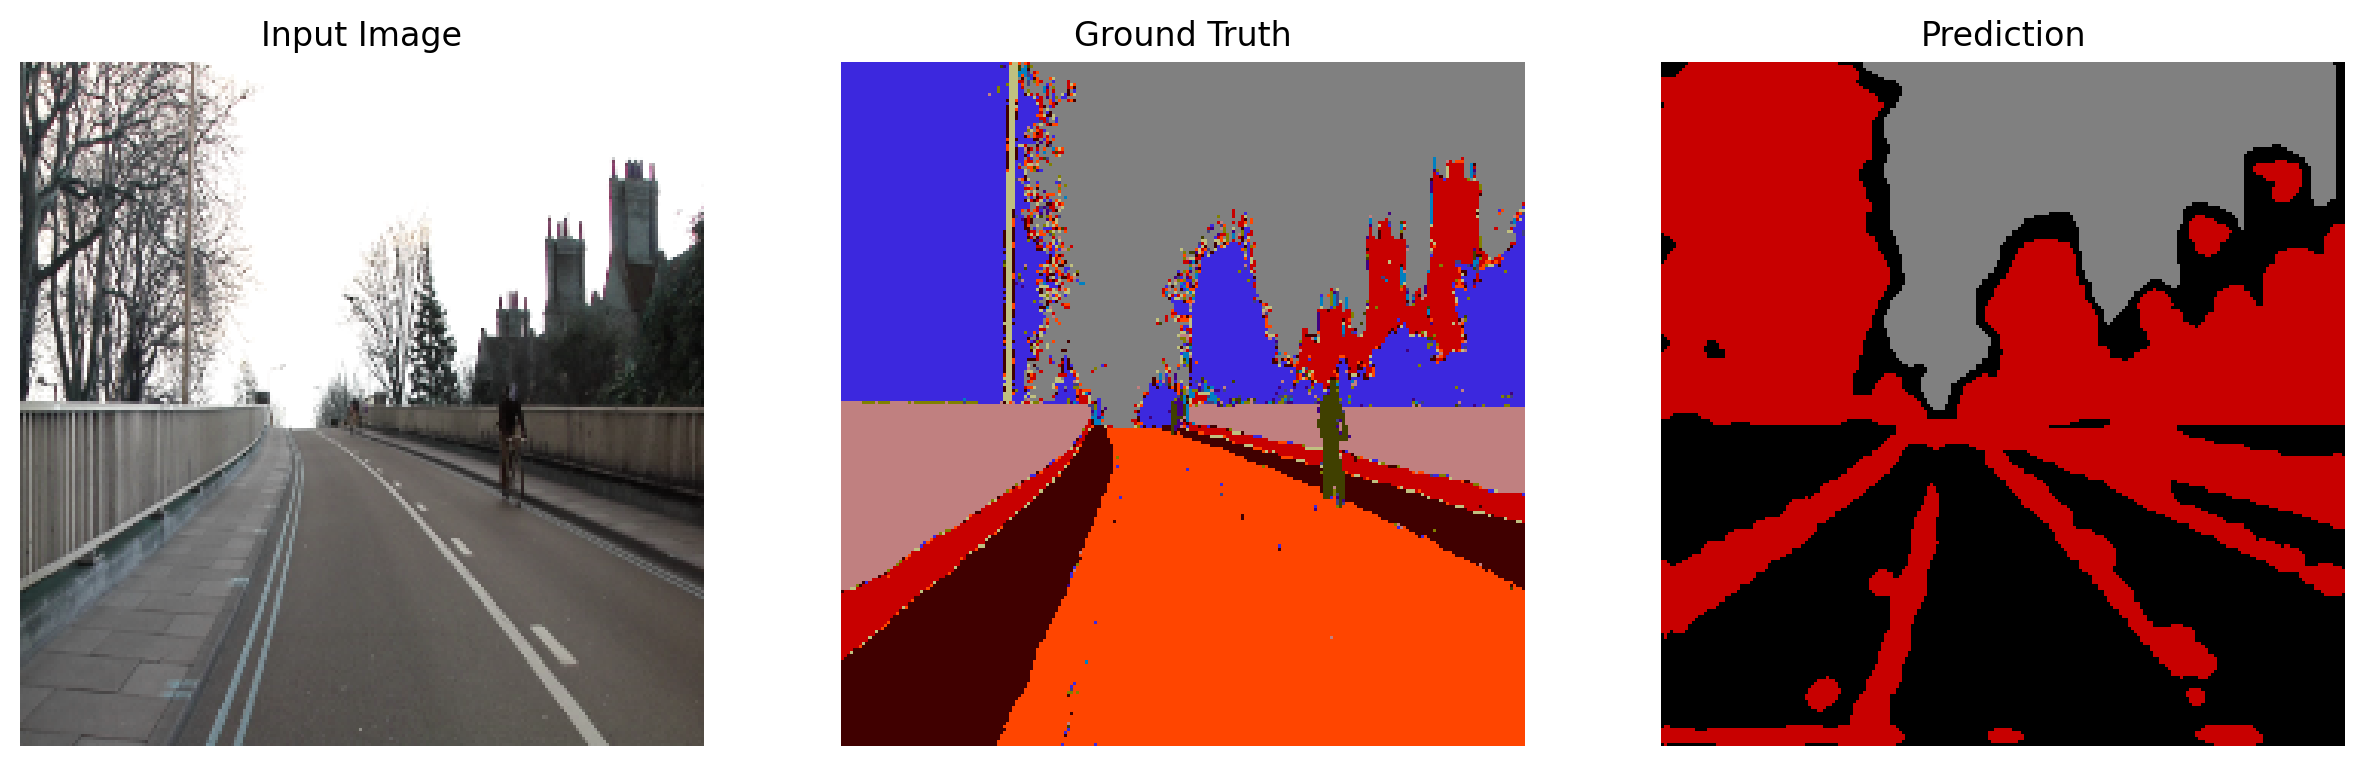

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from tensorflow.keras.models import load_model  # Use this if you need to load a pre-trained model

# Define the visualize function to convert class labels to RGB colors
def visualize(temp, plot=True):
    label_colours = [
        [128, 128, 128],  # Sky
        [200, 0, 0],      # Building
        [192, 192, 128],  # Pole
        [255, 69, 0],     # Road_marking
        [64, 0, 0],       # Road
        [60, 40, 222],    # Pavement
        [128, 128, 0],    # Tree
        [192, 128, 128],  # SignSymbol
        [64, 64, 128],    # Fence
        [64, 0, 128],     # Car
        [64, 64, 0],      # Pedestrian
        [0, 128, 192],    # Bicyclist
        [0, 0, 0]         # Unlabelled
    ]
    label_colours = np.array(label_colours)
    
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in range(12):
        r[temp == l] = label_colours[l, 0]
        g[temp == l] = label_colours[l, 1]
        b[temp == l] = label_colours[l, 2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

# Assuming model is already loaded or defined
# model = load_model('path_to_your_model.h5')  # Uncomment this line if you need to load a pre-trained model

# Predict on the test data
pred = model.predict(X_test, verbose=1)

# Randomly select an index
ranidx = randint(0, len(y_test) - 1)

# Ensure shapes are correct
print(f"Input shape: {X_test[ranidx].shape}")
print(f"Ground truth shape: {y_test[ranidx].shape}")
print(f"Prediction shape: {pred[ranidx].shape}")

# Reshape ground truth and prediction to (224, 224)
y_test_reshaped = np.squeeze(y_test[ranidx], axis=-1)
pred_reshaped = np.squeeze(pred[ranidx], axis=-1)

# Display predictions, ground truth, and input image
plt.figure(dpi=200, figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(X_test[ranidx])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
gt_image = visualize(y_test_reshaped, plot=False)
plt.imshow(gt_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Prediction")
pred_image = visualize(pred_reshaped, plot=False)
plt.imshow(pred_image)
plt.axis('off')

plt.show()


# using more layers in NN

In [64]:
def simple_cnn(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    
    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), padding='same')(x)
    outputs = Activation('sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

input_shape = (224, 224, 3)
model = simple_cnn(input_shape)
model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_11 (UpSampling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 28, 28, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 778,817 (2.97 MB)

 Trainable params: 777,409 (2.97 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
adam_optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model with a reduced batch size
history = model.fit(X_train, y_train,
                    epochs=10,  
                    batch_size=4,  
                    validation_data=(X_valid, y_valid),
                    shuffle=True,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.3588 - loss: -1268.6699
Epoch 1: val_loss improved from inf to -1676.41492, saving model to best_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 231ms/step - accuracy: 0.3588 - loss: -1268.9017 - val_accuracy: 0.3326 - val_loss: -1676.4149 - learning_rate: 0.0010
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.3703 - loss: -1424.6528
Epoch 2: val_loss did not improve from -1676.41492
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 301ms/step - accuracy: 0.3702 - loss: -1425.2732 - val_accuracy: 0.3413 - val_loss: -1323.2361 - learning_rate: 0.0010
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.3714 - loss: -1600.1925
Epoch 3: val_loss did not improve from -1676.41492
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 293ms/step - accuracy: 0.3713 - loss: -1601.1051 - val_accuracy: 0.3409 - val_loss: -1437.2302 - learning_rate: 0.0010
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.3649 - loss: -1849.7722
Epo

In [13]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - accuracy: 0.2661 - loss: -6241.2397
Test Loss: -4861.06640625
Test Accuracy: 0.27550262212753296


# using more layers but with dropout regularization in NN

In [101]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def simple_cnn(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    # Decoder  
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), padding='same')(x)
    outputs = Activation('sigmoid')(x) 
    
    model = Model(inputs, outputs)
    return model

input_shape = (224, 224, 3)
model = simple_cnn(input_shape)

model.summary()

adam_optimizer = Adam(learning_rate=0.0001) 
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_50 (Activation)           │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_51 (Activation)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_52 (Activation)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_27 (UpSampling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 56, 56, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_53 (Activation)           │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_28 (UpSampling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 187,073 (730.75 KB)

 Trainable params: 186,433 (728.25 KB)

 Non-trainable params: 640 (2.50 KB)

In [102]:
history = model.fit(X_train, y_train, epochs=5, batch_size=3, validation_data=(X_valid, y_valid))

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 53s 343ms/step - accuracy: 0.3103 - loss: -1.6200 - val_accuracy: 0.2732 - val_loss: -3.5298
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 43s 345ms/step - accuracy: 0.3240 - loss: -8.1007 - val_accuracy: 0.2822 - val_loss: -8.3973
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 43s 352ms/step - accuracy: 0.3219 - loss: -14.2888 - val_accuracy: 0.3202 - val_loss: -15.2919
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 44s 361ms/step - accuracy: 0.3318 - loss: -20.9373 - val_accuracy: 0.3315 - val_loss: -42.1196
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 45s 365ms/step - accuracy: 0.3459 - loss: -27.8666 - val_accuracy: 0.3385 - val_loss: -50.7168


In [103]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - accuracy: 0.3433 - loss: -71.4201
Test Loss: -47.3484, Test Accuracy: 0.3761
